In [60]:
import tensorflow as tf
import tensorflow_datasets as tfds
# import layers 
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [61]:
data, info = tfds.load("rock_paper_scissors", with_info=True, as_supervised=True)
train_data = data["train"]
test_data = data["test"]

2024-03-30 00:46:02.793303: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-30 00:46:02.805401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


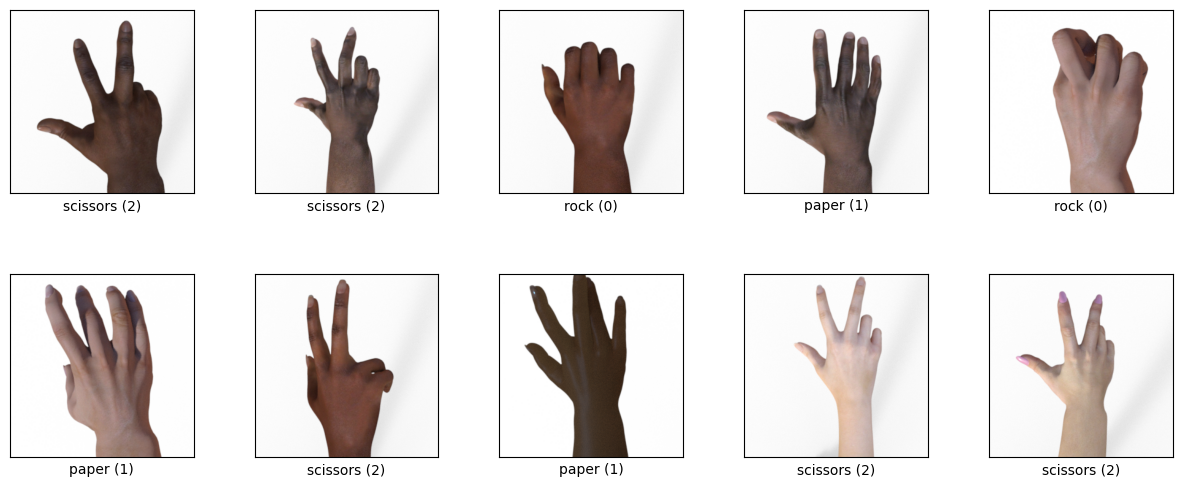

In [62]:
# get some examples
fig = tfds.show_examples(train_data, info, rows=2, cols=5)

Size of the dataset

In [63]:
print("Train set size:", info.splits["train"].num_examples)
print("Test set size:", info.splits["test"].num_examples)

Train set size: 2520
Test set size: 372


In [64]:
# print all the classes
print("Classes:", info.features["label"].names)

Classes: ['rock', 'paper', 'scissors']


In [65]:
# count occurrences of each class
train_counts = [0, 0, 0]
test_counts = [0, 0, 0]
for image, label in train_data:
    train_counts[label] += 1
for image, label in test_data:
    test_counts[label] += 1

print("Train counts:", train_counts)
print("Test counts:", test_counts)

Train counts: [840, 840, 840]
Test counts: [124, 124, 124]


2024-03-30 00:46:03.866341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 00:46:04.013472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [66]:
# get input size
input_shape = info.features["image"].shape
print("Input shape:", input_shape)

Input shape: (300, 300, 3)


In [67]:
train_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=2520>

In [68]:
# shuffle and split the data to train and validation

train_data = train_data.shuffle(train_data.cardinality(), seed=42)

val_size = 0.1
val_data = train_data.take(int(val_size * info.splits["train"].num_examples))
train_data = train_data.skip(int(val_size * info.splits["train"].num_examples))

In [69]:
# convert to batch size of 32
batch_size = 32

train_data = train_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# print the shapes
for img, label in train_data.take(1):
    print("Train data shape:", img.shape)
    print("Train label shape:", label.shape)
    
for img, label in val_data.take(1):
    print("Val data shape:", img.shape)
    print("Val label shape:", label.shape)

Train data shape: (32, 300, 300, 3)
Train label shape: (32,)
Val data shape: (32, 300, 300, 3)
Val label shape: (32,)


2024-03-30 00:46:04.118768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 00:46:04.132980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [70]:
num_classes = info.features["label"].num_classes

## First model with hardcoded parameters

In [ ]:
firstModel = tf.models.Sequential([
  # resize and rescale
  layers.preprocessing.Resizing(input_shape[0], input_shape[1]),
  layers.experimental.preprocessing.Rescaling(1./255),

  # augmentations
  layers.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.preprocessing.RandomRotation(0.2),

  # convolutions
  layers.Conv2D(32, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.Dense(num_classes, activation="softmax")
])

In [71]:
tf.keras.backend.clear_session()

from tensorboard.plugins.hparams import api as hp

HP_LAYER_1_UNITS = hp.HParam("layer_1_units", hp.Discrete([32, 64]))
HP_LAYER_2_UNITS = hp.HParam("layer_2_units", hp.Discrete([64, 128]))
HP_LAYER_3_UNITS = hp.HParam("layer_3_units", hp.Discrete([64]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([0.001]))
HP_L2_REGULARIZATION = hp.HParam("l2_regularization", hp.Discrete([0.1, 0.01]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.3]))

METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer("logs/hparam_tuning").as_default():
    hp.hparams_config(
        hparams=[HP_LAYER_1_UNITS, HP_LAYER_2_UNITS, HP_LAYER_3_UNITS, HP_LEARNING_RATE, HP_L2_REGULARIZATION, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy")],
    )

In [72]:
def train_and_test_model(hparams):
    model = tf.keras.Sequential([
        layers.InputLayer(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(hparams[HP_LAYER_1_UNITS], kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2_REGULARIZATION])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(hparams[HP_LAYER_2_UNITS], kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2_REGULARIZATION])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Flatten(),
        layers.Dense(hparams[HP_LAYER_3_UNITS], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2_REGULARIZATION])),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    history = model.fit(train_data, validation_data=val_data, epochs=5, verbose = 0)

    _, accuracy = model.evaluate(test_data, verbose=0)
    return accuracy, history

In [73]:
def run_model(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy, history = train_and_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        tf.summary.scalar("val_accuracy", history.history["val_accuracy"][-1], step=1)
        return accuracy

In [74]:
session_num = 0

for layer_1_units in HP_LAYER_1_UNITS.domain.values:
    for layer_2_units in HP_LAYER_2_UNITS.domain.values:
        for layer_3_units in HP_LAYER_3_UNITS.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                for l2_regularization in HP_L2_REGULARIZATION.domain.values:
                    for dropout in HP_DROPOUT.domain.values:
                        hparams = {
                            HP_LAYER_1_UNITS: layer_1_units,
                            HP_LAYER_2_UNITS: layer_2_units,
                            HP_LAYER_3_UNITS: layer_3_units,
                            HP_LEARNING_RATE: learning_rate,
                            HP_L2_REGULARIZATION: l2_regularization,
                            HP_DROPOUT: dropout
                        }
                        run_name = "run-%d" % session_num
                        print("--- Starting trial: %s" % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        # acc, _ = train_and_test_model(hparams)
                        acc = run_model("logs/hparam_tuning/" + run_name, hparams)
                        print("Test accuracy: %f" % acc)
                        session_num += 1

--- Starting trial: run-0
{'layer_1_units': 32, 'layer_2_units': 64, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.01, 'dropout': 0.3}
Test accuracy: 0.833333
--- Starting trial: run-1
{'layer_1_units': 32, 'layer_2_units': 64, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.1, 'dropout': 0.3}
Test accuracy: 0.559140
--- Starting trial: run-2
{'layer_1_units': 32, 'layer_2_units': 128, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.01, 'dropout': 0.3}
Test accuracy: 0.653226
--- Starting trial: run-3
{'layer_1_units': 32, 'layer_2_units': 128, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.1, 'dropout': 0.3}
Test accuracy: 0.739247
--- Starting trial: run-4
{'layer_1_units': 64, 'layer_2_units': 64, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.01, 'dropout': 0.3}
Test accuracy: 0.733871
--- Starting trial: run-5
{'layer_1_units': 64, 'layer_2_units': 64, 'layer_3_units': 64, 'lear

Shows that the base model works with these params
{'layer_1_units': 64, 'layer_2_units': 64, 'layer_3_units': 64, 'learning_rate': 0.001, 'l2_regularization': 0.01, 'dropout': 0.3}

In [ ]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(64, 3, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

In [ ]:
epochs = 20
history = model.fit(
  train_data,
  validation_data = val_data,
  epochs = epochs,
  verbose = 2,
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

In [ ]:
# print the training and validation accuracy
print("Training Accuracy", history.history['accuracy'])
print("Validation Accuracy", history.history['val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# check on the test data

loss, accuracy = model.evaluate(test_data)

Confusion matrix for this model

In [ ]:
predicted_labels = model.predict(test_data)
predicted_labels = tf.argmax(predicted_labels, axis=1)

test_labels = []
for img, label in test_data:
    test_labels.extend(label.numpy())
test_labels = tf.convert_to_tensor(test_labels)

tf.math.confusion_matrix(test_labels, predicted_labels, num_classes=num_classes)

Group predicted labels by class

In [ ]:
# grp predicted labels by class
predictedClassCnts = [0, 0, 0]
for i in predicted_labels:
    predictedClassCnts[i] += 1
print("Predicted class counts:", predictedClassCnts)

so many predictions go towards "paper"

In [ ]:
# get precision and recall
conf_matrix = tf.math.confusion_matrix(test_labels, predicted_labels, num_classes=num_classes)
conf_matrix = tf.cast(conf_matrix, tf.float32)

precision = tf.linalg.diag_part(conf_matrix) / tf.reduce_sum(conf_matrix, axis=0)
recall = tf.linalg.diag_part(conf_matrix) / tf.reduce_sum(conf_matrix, axis=1)

print("Precision:", precision)
print("Recall:", recall)

In [ ]:
# get the false negatives and false positives
false_negatives = tf.reduce_sum(conf_matrix, axis=1) - tf.linalg.diag_part(conf_matrix)
false_positives = tf.reduce_sum(conf_matrix, axis=0) - tf.linalg.diag_part(conf_matrix)

print("False Negatives:", false_negatives)
print("False Positives:", false_positives)

## Stacked Model

In [ ]:
stackedConvs = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(64, 3, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Conv2D(32, 3, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Dense(num_classes, activation="softmax")
])

stackedConvs.summary()

In [ ]:
stackedConvs.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
stackedConvs_history = stackedConvs.fit(
    train_data,
    validation_data = val_data,
    epochs = epochs,
    verbose = 1,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

In [ ]:
# plot the stackedConvs_history
acc = stackedConvs_history.history['accuracy']
val_acc = stackedConvs_history.history['val_accuracy']

loss = stackedConvs_history.history['loss']
val_loss = stackedConvs_history.history['val_loss']

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = stackedConvs.evaluate(test_data)

In [ ]:
# predict labels and and convert to 1d tensors
predictions = stackedConvs.predict(test_data)
predicted_labels = tf.argmax(predictions, axis=1)

In [ ]:
# convert test data labels to 1d tensors
test_labels = []
for img, label in test_data:
    test_labels.extend(label.numpy())
test_labels = tf.convert_to_tensor(test_labels)

Confusion matrix for stacked model

In [ ]:
tf.math.confusion_matrix(
    test_labels,
    predicted_labels,
    num_classes=num_classes
)

In [ ]:
(77 + 94 + 49) / test_labels.shape[0]